<a href="https://colab.research.google.com/github/brendanpshea/database_sql/blob/main/Database_08_IndexesTransactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Database Performance: Index, Query Plans, and Transaction Management
In this chapter, we will explore the inner workings of SQLite using a dataset from the fictional Gotham National Bank. Our focus will be on understanding how indexes, transactions, and database monitoring can optimize SQLite database performance and ensure smooth operations. We will cover the fundamentals of indexes, demonstrate their impact on query speed and database size, and discuss best practices for implementing them effectively.

Additionally, we will delve into the concept of transactions and the crucial role they play in ensuring data integrity and reliability. We will examine the ACID properties that transactions must adhere to and showcase how to work with transactions in SQLite using commands like BEGIN, COMMIT, and ROLLBACK.

Furthermore, we will emphasize the importance of database monitoring, reporting, and logging in maintaining the health and performance of SQLite databases. We will explore various monitoring techniques, discuss the types of logs generated, and highlight the tools and practices used by database administrators like ORACLE to keep databases running optimally.

Throughout the chapter, we will use practical examples and step-by-step explanations to illustrate how indexes, transactions, and monitoring can be leveraged to build robust and efficient databases. By the end, you should have a solid foundation in these key concepts and be well-equipped to apply them in your own SQLite projects.

Learning Outcomes:

1.  Understand the purpose and benefits of indexes in SQLite databases
2.  Learn how to create indexes and analyze their impact on query performance and database size
3.  Recognize situations where creating an index is advantageous and when it may not be necessary
4.  Grasp the concept of transactions and their importance in maintaining data integrity and reliability
5.  Become familiar with the ACID properties of transactions and their implications for database consistency
6.  Learn how to work with transactions in SQLite using BEGIN, COMMIT, ROLLBACK, and SAVEPOINT commands
7.  Understand the challenges of concurrent transactions and the role of locking mechanisms in managing simultaneous access to data
8.  Appreciate the significance of database monitoring, reporting, and logging in ensuring optimal performance and health of SQLite databases
9.  Gain insights into the tools and techniques used by database administrators to monitor and manage databases effectively

Keywords: SQLite, indexes, transactions, database monitoring, reporting, logging, query performance, database size, ACID properties, data integrity, reliability, concurrency, locking




## Image: Batman and Oracle at the Bank
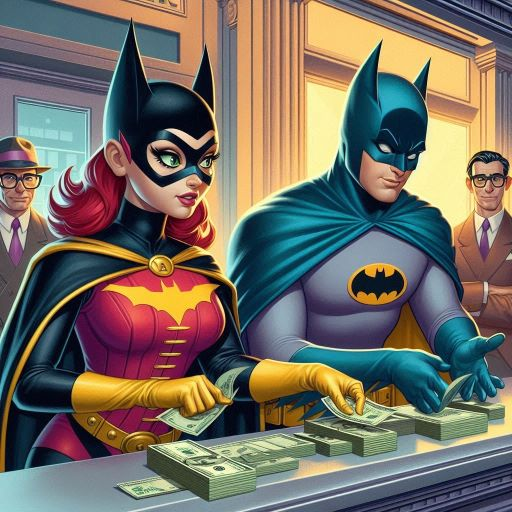

## Gotham National Bank Database
In this chapter, we'll be exploring the inner workings of **SQLite** using a dataset from the fictional **Gotham National Bank**. Our database, *gotham.db*, contains two tables:

1.  **Customers**: Stores customer information like name, address, and contact details.
2.  **Accounts**: Holds account-related data such as account type, balance, and creation date, with a foreign key linking to the Customers table.

Throughout this chapter, we'll use these tables to understand how **indexes** and **transactions** can optimize our SQLite database performance. We'll cover the fundamentals of indexes, demonstrate their impact on query speed and database size, and discuss best practices for implementing them effectively.

In [ ]:
!wget https://github.com/brendanpshea/database_sql/raw/main/data/gotham.db -q -nc
%load_ext sql
%sql sqlite:///gotham.db


## Database Schema for Gotham City Bank
Here is the database schema.

In [ ]:
%%sql
-- we are going to turn on "profiling" this lesson
PRAGMA profile = 1;
-- get table schema using sqlite master
SELECT sql FROM sqlite_master WHERE type='table';

 * sqlite:///gotham.db
Done.
Done.


sql
"CREATE TABLE Customers ( CustomerID INTEGER PRIMARY KEY AUTOINCREMENT, FirstName VARCHAR(50) NOT NULL, LastName VARCHAR(50) NOT NULL, MiddleInitial CHAR(1), Address VARCHAR(255), City VARCHAR(50), State VARCHAR(50), ZipCode VARCHAR(10), PhoneNumber VARCHAR(15), Email VARCHAR(100))"
"CREATE TABLE sqlite_sequence(name,seq)"
"CREATE TABLE Accounts ( AccountID INTEGER PRIMARY KEY AUTOINCREMENT, CustomerID INT, AccountType VARCHAR(20), Balance DECIMAL(15, 2) DEFAULT 0.00, CreatedDate DATE, FOREIGN KEY (CustomerID) REFERENCES Customers(CustomerID))"


## A Closer Look at Customers and Accounts
Now, let's take a quick look at the head of our table.

In [ ]:
%%sql
SELECT * FROM Customers LIMIT 5;

 * sqlite:///gotham.db
Done.


CustomerID,FirstName,LastName,MiddleInitial,Address,City,State,ZipCode,PhoneNumber,Email
1,Bruce,Wayne,None,1007 Mountain Drive,Gotham,NY,10001,123-456-7890,bruce.wayne@gothambank.com
2,Selina,Kyle,None,123 Cat St,Blüdhaven,NY,20002,234-567-8901,selina.kyle@gothambank.com
3,James,Gordon,None,789 Police Plaza,Gotham,NY,10003,345-678-9012,james.gordon@gothambank.com
4,Harvey,Dent,None,456 Lawyer Ave,Metropolis,NY,30004,456-789-0123,harvey.dent@gothambank.com
5,Pamela,Isley,None,369 Botanic St,Gotham,NY,10005,567-890-1234,pamela.isley@gothambank.com


In [ ]:
%%sql
SELECT * FROM Accounts LIMIT 5;

 * sqlite:///gotham.db
Done.


AccountID,CustomerID,AccountType,Balance,CreatedDate
1,1,Checking,15000,2021-01-10
2,1,Savings,75000,2021-02-11
3,2,Checking,32000,2022-03-05
4,3,Checking,86000,2023-04-15
5,4,Checking,22000,2024-05-20


## What are Indexes and How Do I Create Them?

If you've ever used a book index to quickly locate a specific topic, you already understand the basic concept of a database **index**. In the context of databases, an index is a separate data structure that allows the database engine to find and retrieve data more efficiently without having to scan the entire table.

When you create a table, SQLite (like all versions of SQL) automatically creates a unique index on the **primary key** column(s). However, you can also create additional indexes on other columns to speed up frequently used queries.

To create an index in SQL, you use the **CREATE INDEX** statement with the following syntax:

```sql
CREATE [UNIQUE] INDEX index_name
ON table_name (column1 [, column2, ...]);
```

Here's a breakdown of the components:

-   `UNIQUE`: Optional keyword that creates a unique index, ensuring no duplicate values in the indexed column(s).
-   `index_name`: The name you want to give your index.
-   `table_name`: The name of the table on which you're creating the index.
-   `column1, column2, ...`: The column(s) to be indexed. You can index multiple columns by separating them with commas.

For example, let's say we want to create an index on the *LastName* column of our *Customers* table:!

In [ ]:
%%sql
DROP INDEX IF EXISTS idx_customers_lastname;
CREATE INDEX idx_customers_lastname
ON Customers (LastName);

 * sqlite:///gotham.db
Done.
Done.


[]

This statement creates an index named idx_customer_lastname on the LastName column, allowing for faster searches based on customer last names. This will allow us to search customers by their last name more quickly.

SQLite supports several types of indexes, including **unique indexes**, which ensure that the indexed column(s) contain no duplicate values, and partial indexes, which only index a subset of rows based on a specified condition.

By default, SQLite (like other RDBMSs) creates a **clustered index** for the primary key of every table, without you needing to do anything. This means that items are physically "clustered together" on disk (so, a record with id=1 is next to the record with id=2). THe `CREATE INDEX` command creates what is a called a **non-clustered** index, meaning that the indexes records that are NOT physically next to each other. (We'll see more on how this works later). There can be only one clustered index per table, but any number of non-clustered indexes.

Creating appropriate indexes is crucial for optimizing database performance, but how do they actually impact query speed? In the next section, we'll explore the power of indexes in action using the EXPLAIN QUERY PLAN command and some practical examples from our Gotham City dataset.

## How Indexes Impact Speed

To understand the impact of indexes on query speed, we'll use the **EXPLAIN QUERY PLAN** command. This command provides insight into how SQLite executes a query, including which indexes (if any) are being used.

Let's start with an example query on our *Accounts* table that gets customers with higher than average balances

In [ ]:
%%sql
SELECT * FROM Accounts
WHERE Balance > (SELECT AVG(Balance) FROM Accounts)
ORDER BY Balance DESC
LIMIT 5;

 * sqlite:///gotham.db
Done.


AccountID,CustomerID,AccountType,Balance,CreatedDate
8136,7952,Savings,92802.15340000001,2003-01-18
3401,4699,Savings,91534.3495,2015-03-25
304,277,Savings,91283.00280000002,2021-05-08
10,8,Checking,91000,2024-10-10
5953,5751,Savings,90689.35260000001,2013-12-29


Now, let's see what the "query plan" is for this:

In [ ]:
%%sql
DROP INDEX IF EXISTS idx_accounts_balance;

EXPLAIN QUERY PLAN
SELECT * FROM Accounts
WHERE Balance > (SELECT AVG(Balance) FROM Accounts)
ORDER BY Balance DESC;

 * sqlite:///gotham.db
Done.
Done.


id,parent,notused,detail
3,0,0,SCAN Accounts
8,0,0,SCALAR SUBQUERY 1
13,8,0,SCAN Accounts
31,0,0,USE TEMP B-TREE FOR ORDER BY


If you look at the query plan here, you'll notice a few key terms that pop out:

-   **Full Table Scan**: A full table scan occurs when SQLite reads every row in a table to find the data that matches the query conditions. In this case, `SCAN Accounts` indicates that SQLite is performing a full table scan on the *Accounts* table. Full table scans can be inefficient, especially for large tables, as they require reading and checking every single row. This will change when we create an index.
-   **Scalar Subquery**: A scalar subquery is a subquery that returns a single value. In this example, `SCALAR SUBQUERY 1` refers to the subquery `(SELECT AVG(Balance) FROM Accounts)`, which calculates the average balance of all accounts. The result of this subquery is used in the main query's WHERE clause.
-   **Temporary B-Tree**: In this case, `USE TEMP B-TREE FOR ORDER BY` indicates that SQLite is using a temporary B-tree data structure to sort the result set in descending order by the *Balance* column. We'll dive deeper into B-trees in a future section.

### Impact of Indexes

If an index were created on the `Balance` column, the query execution plan would likely be different. For example, with an index on `Balance`, the execution plan might show an **index search** instead of a full table scan, resulting in faster query execution times.

To create an index on the `Balance` column, you could use the following command:

In [ ]:
%%sql
CREATE INDEX idx_accounts_balance
ON Accounts (Balance);

 * sqlite:///gotham.db
Done.


[]

Now, let's see what happens to our query plan:

In [ ]:
%%sql
EXPLAIN QUERY PLAN
SELECT * FROM Accounts
WHERE Balance > (SELECT AVG(Balance) FROM Accounts)
ORDER BY Balance DESC;

 * sqlite:///gotham.db
Done.


id,parent,notused,detail
4,0,0,SEARCH Accounts USING INDEX idx_accounts_balance (Balance>?)
8,0,0,SCALAR SUBQUERY 1
13,8,0,SCAN Accounts USING COVERING INDEX idx_accounts_balance


SQLite now uses the idx_account_balance index to search for matching rows, resulting in a more efficient query execution. Instead of scanning the entire table, it can quickly locate the relevant rows using the index.

Some new terms you'll notice:

1.  **Index Scan**: An index scan is a type of table access that uses an index to locate the required data. In this example, `SEARCH Accounts USING INDEX idx_accounts_balance (Balance>?)` means that SQLite is using the *idx_accounts_balance* index to find rows where the *Balance* is greater than the result of the scalar subquery.
2.  **Covering Index**: A covering index is an index that contains all the columns required to satisfy a query, eliminating the need for additional table lookups. In the updated plan, `SCAN Accounts USING COVERING INDEX idx_accounts_balance` indicates that the *idx_accounts_balance* index is a covering index for the subquery. This means that all the data needed to calculate the average balance is available within the index itself, making the query more efficient.


## Timing Our Queries
To further demonstrate the performance impact, let's measure the execution time of our query with and without the index. We'll be using Colab's builtin **timeit** function, which will run this query many times, and give us the average runninng time. This helps miminize the role of chance in evaluating query performance based on a single case.

In [ ]:
%%sql
-- to start, drop the index
DROP INDEX idx_accounts_balance;

 * sqlite:///gotham.db
Done.


[]

In [ ]:
%%timeit -n 1
%%sql
-- This will run this query many times
SELECT * FROM Accounts
WHERE Balance > (SELECT AVG(Balance) FROM Accounts)
ORDER BY Balance DESC;

 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
78.7 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%sql
-- Recreate our index
CREATE INDEX idx_accounts_balance
ON Accounts (Balance);

 * sqlite:///gotham.db
Done.


[]

In [ ]:
%%timeit -n 1
%%sql
-- Now run the query with the index
SELECT * FROM Accounts
WHERE Balance > 25000 AND  Balance < 50000;

 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
 * sqlite:///gotham.db
Done.
51.3 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


While the specific results you get will vary each time you run the test, you should find that (on average) the index scan runs a bit faster than the full table scan.

## How Indexes Impact Storage
Now that we've seen how indexes can significantly improve query performance, let's explore how they impact database storage. To understand this, we first need to discuss how SQLite (and many other databases) store data using a data structure called a B-tree.

### B-trees: The Backbone of Database Storage

A B-tree is a self-balancing tree data structure that maintains sorted data and allows for efficient insertion, deletion, and search operations. B-trees are particularly well-suited for databases because they optimize disk I/O operations, which is crucial when dealing with large amounts of data that cannot fit entirely in memory.

In a B-tree, each node contains multiple keys and pointers to child nodes. The keys within a node are kept in sorted order, and each key is associated with two pointers:

1.  A pointer to the child node containing keys less than the current key.
2.  A pointer to the child node containing keys greater than or equal to the current key.

This structure allows for quick traversal and search operations, as the database can navigate the tree by comparing the desired key with the keys in each node and following the appropriate pointers.

### How SQLite Uses B-trees

SQLite uses B-trees to store both tables and indexes. When you create a table, SQLite creates a B-tree where each node contains one or more rows of data. The rows within a node are sorted by the primary key, enabling efficient lookups and range queries.

For example, let's consider a simplified representation of the *Accounts* table:

```
AccountID | CustomerID | Balance
1         | 1          | 10000
2         | 1          | 5000
3         | 2          | 7500
4         | 3          | 12000`
```

In the table's B-tree, the rows would be stored in nodes, sorted by the primary key (AccountID):

```
Node 1: (1, 1, 10000) | (2, 1, 5000)
Node 2: (3, 2, 7500)  | (4, 3, 12000)
```

When you create an index on a column, SQLite generates a separate B-tree specifically for that index. The index B-tree stores the indexed column's values along with pointers to the corresponding rows in the table's B-tree.

Let's say we create an index on the *Balance* column. Then the *idx_accounts_balance* index B-tree would store the *Balance* values in sorted order, along with pointers to the corresponding rows in the *Accounts* table's B-tree:

```sql
Node 1: (5000, pointer to row 2) | (7500, pointer to row 3)
Node 2: (10000, pointer to row 1) | (12000, pointer to row 4)
```

When you query the table using the indexed column, SQLite can quickly traverse the index B-tree to find the matching values and then follow the pointers to retrieve the full row data from the table's B-tree.

By using B-trees for both tables and indexes, SQLite ensures efficient data storage and retrieval, even for large datasets. However, it's important to keep in mind that creating indexes also requires additional storage space, as each index maintains its own B-tree structure.


### Graphic: B-Trees
Here's what our B-tree for our original table might look like:


In [ ]:
import base64
from IPython.display import Image, display, HTML

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))


mm("""
graph TB
  subgraph Accounts Table B-tree - sorting by id
    N1((Node 1)) <--> |pointer to next/previous node| N2((Node 2))
    N1 --- |contains| A1[AccountID - key: 1<br>CustomerID: 1<br>Balance: 10000]
    N1 --- |contains| A2[AccountID - key: 2<br>CustomerID: 1<br>Balance: 5000]
    N2 --- |contains| A3[AccountID - key: 3<br>CustomerID: 2<br>Balance: 7500]
    N2 --- |contains| A4[AccountID - key: 4<br>CustomerID: 3<br>Balance: 12000]
  end
""")

And here's what the B-tree for the index might look like:

In [ ]:
mm("""
graph TB
  subgraph Balance Index B-tree - sorting by balance
    IN1((Node 1)) <--> | points to next/previous node | IN2((Node 2))
    IN1 --- |contains| IA2[Balance - key: 5000<br>Pointer to Account 2]
    IN1 --- |contains| IA3[Balance - key: 7500<br>Pointer to Account 3]
    IN2 --- |contains| IA1[Balance - key: 10000<br>Pointer to Account 1]
    IN2 --- |contains| IA4[Balance - key: 12000<br>Pointer to Account 4]
  end
"""
)

### Checking File Size
Because indexes require the construction of new B-trees, they require additional disk space. We can  check the file size (using Windows, Linux, etc.). Let's first first check the size our database:

In [ ]:
# In ubuntu du gives file size
!du -h gotham.db

1.9M	gotham.db


Now, let's see what happens when we an index.

In [ ]:
%%sql
DROP INDEX IF EXISTS idx_accounts_balance;
-- create an index based on first name, last name, phone
CREATE INDEX idx_customers_first_last_phone
ON Customers (FirstName, LastName, PhoneNumber);

 * sqlite:///gotham.db
Done.
Done.


[]

In [ ]:
# Now, we can check the size again
!du -h gotham.db

2.0M	gotham.db


While your results migth vary somewhat, here's what I got from running these commands:

- The database size before building the index was 1.9 mb
- The database size after building the index was 2.2 mb.

This is a large difference--over 10%--and reinforces the principle that indexes (especially ones that combine multiple columns) need to be used with care.

## ORACLE's Guide to Creating Indexes

Hello, aspiring database heroes! I'm ORACLE (formerly "Batgirl"), your trusty guide through the complex world of SQLite indexing. As the all-seeing database sage of Gotham City, I'm here to share some wisdom on when and how to create indexes for your tables.

First, let's set the scene. Imagine you're working for the Gotham City Police Department (GCPD), and you've been tasked with optimizing their criminal database. The database contains tables like *Suspects*, *Crimes*, and *Investigations*, each with thousands of rows. Your job is to ensure that queries run faster than the Batmobile on a pursuit.

### When to Create an Index

1.  *Frequently Used Columns*. If you find yourself constantly querying the database to find suspects by their last name, it's a good idea to create an index on the *LastName* column of the *Suspects* table. This way, when Commissioner Gordon asks for information on "Napier," the database can quickly locate the relevant records without having to scan the entire table.
2.  *JOIN Columns*. When you're joining tables based on a foreign key, such as joining the *Crimes* and *Investigations* tables on the *CrimeID* column, creating an index on the foreign key column can significantly speed up the JOIN operation. This is particularly important when dealing with large tables, as it helps avoid full table scans.
3.  *Columns Used in ORDER BY or GROUP BY*. If you frequently sort the results of your queries, like displaying the list of crimes ordered by the date they occurred, consider creating an index on the column used in the ORDER BY clause. The same goes for columns used in GROUP BY clauses. Indexes help optimize these operations by allowing SQLite to quickly sort or group the data without having to perform a full table scan.

### When Not to Create an Index

1.  *Small Tables*. If your table is small, like a list of Gotham's most notorious villains (which hopefully doesn't grow too large), creating an index might not provide significant performance benefits. The overhead of maintaining the index could outweigh the time saved during queries.
2.  *Columns with Low Cardinality*. Cardinality refers to the number of unique values in a column. If a column has low cardinality, such as a *VillainStatus* column with only a few possible values ("At Large," "In Custody," "Reformed"), creating an index on that column might not be effective. SQLite would still need to scan a large portion of the index to find the desired values.
3.  *Frequently Updated Columns*. If a column is frequently updated, like the *CurrentLocation* of a suspect, creating an index on that column could slow down the update operations. Each time the column is updated, SQLite needs to update both the table and the index B-tree, causing additional overhead.

### Analyzing Query Plans and Execution Speed

Before creating an index, it's essential to analyze the current query plans and execution speeds. Use the `EXPLAIN QUERY PLAN` command to see how SQLite is executing your queries. If you notice full table scans or suboptimal execution plans, consider creating an index on the columns involved.

For example, let's say you have a query that searches for crimes committed by a specific suspect:

```sql
EXPLAIN QUERY PLAN
SELECT * FROM Crimes
WHERE SuspectID = (SELECT SuspectID FROM Suspects WHERE LastName = 'Joker');
```

If the query plan shows a full table scan on the *Suspects* table, creating an index on the *LastName* column could improve the query's performance.

Remember, indexes are like Robin to your Batman - they're there to help you fight crime (or in this case, slow queries). But just like how Batman doesn't bring Robin to every mission, you don't need an index on every column. Use them wisely, and your database will be the hero Gotham deserves!

## Introduction to Transactions and ACID Properties

When working with databases, ensuring data integrity and reliability is crucial. This is where transactions come into play. A **transaction** is a sequence of database operations that are treated as a single unit of work. Transactions are designed to maintain the consistency and integrity of the database, even in the face of failures or concurrent access by multiple users.

To better understand transactions, let's consider an example from our Gotham City bank database. Imagine that Bruce Wayne wants to transfer $10,000 from his savings account to his checking account. This transaction would involve two steps:

1.  Deducting \$10,000 from Bruce's savings account.
2.  Adding \$10,000 to Bruce's checking account.

If either of these steps fails, the entire transaction should be rolled back to maintain the consistency of the database. We wouldn't want to deduct the money from the savings account without adding it to the checking account, or vice versa.

### ACID Properties

To ensure the reliability and consistency of transactions, they must adhere to the ACID properties:

1.  **Atomicity**. A transaction must be treated as an atomic unit of work, meaning that either all of its operations are completed successfully, or none of them are. If any part of the transaction fails, the entire transaction is rolled back, and the database is left unchanged. In our example, if the deduction from the savings account succeeds, but the addition to the checking account fails, the transaction would be rolled back, and the savings account would be restored to its original balance.
2.  **Consistency**. A transaction must take the database from one consistent state to another. This means that the transaction must ensure that all data integrity constraints are satisfied before it completes. For example, if our bank database has a constraint that account balances cannot be negative, any transaction that would result in a negative balance must be rolled back to maintain consistency.
3.  **Isolation**. Transactions must be isolated from one another. This means that the intermediate state of a transaction should not be visible to other transactions. Each transaction should execute as if it were the only one running on the database. This isolation helps prevent issues like dirty reads (reading uncommitted data from another transaction) and non-repeatable reads (getting different results from the same query within a single transaction due to changes made by other transactions).
4.  **Durability**. Once a transaction is committed, its changes must be permanently stored in the database, even in the event of system failures. This durability is typically achieved through the use of transaction logs and other recovery mechanisms that ensure that committed changes are not lost.

By adhering to the ACID properties, transactions help maintain the integrity and reliability of the database, even in the face of failures and concurrent access.

## Transactions in SQLite

Now that we understand the concept of transactions and the ACID properties, let's explore how to work with transactions in SQLite.

### SQLite's Autocommit Mode

By default, SQLite operates in autocommit mode. In this mode, each individual SQL statement is treated as a separate transaction and is automatically committed when it completes successfully. If an error occurs during the execution of a statement, any changes made by that statement are automatically rolled back.

While autocommit mode is convenient for simple queries and updates, it may not be suitable for situations where you need to ensure that a group of related statements are executed as a single unit of work.

### Explicit Transactions

To group multiple SQL statements into a single transaction, you can use the `BEGIN`, `COMMIT`, and `ROLLBACK` commands.

1.  `BEGIN`. This command starts a new transaction. Any subsequent SQL statements will be part of this transaction until a `COMMIT` or `ROLLBACK` command is issued.
2.  `COMMIT`. This command commits the current transaction, making all the changes made within the transaction permanent. After a `COMMIT`, the database is in a new consistent state.
3.  `ROLLBACK`. This command rolls back the current transaction, undoing all the changes made within the transaction. After a `ROLLBACK`, the database is restored to the state it was in before the transaction began.

Here's an example of using explicit transactions in SQLite (since the environment we are in automatically auto-commits, we can't actually run the code):

```sql
-- Begin a transaction
BEGIN;

-- Deduct $10,000 from Bruce's savings account
UPDATE Accounts SET Balance = Balance - 10000 WHERE AccountID = 2;

-- Add $10,000 to Bruce's checking account
UPDATE Accounts SET Balance = Balance + 10000 WHERE AccountID = 1;

-- Commit the transaction
COMMIT;
```

In this example, we start a transaction with the `BEGIN` command. We then execute two `UPDATE` statements to transfer $10,000 from Bruce's savings account to his checking account. Finally, we use the `COMMIT` command to make the changes permanent.

If an error occurs during the transaction, we can use the `ROLLBACK` command to undo all the changes and restore the database to its previous state:

```sql
-- Begin a transaction
BEGIN;

-- Deduct $10,000 from Bruce's savings account
UPDATE Accounts SET Balance = Balance - 10000 WHERE AccountID = 2;

-- Oops, an error occurs!
UPDATE Accounts SET Balance = Balance + 10000 WHERE AccountID = 99999; -- Invalid AccountID

-- Rollback the transaction
ROLLBACK;
```

In this case, the second `UPDATE` statement fails because the specified `AccountID` doesn't exist. By issuing a `ROLLBACK` command, we undo both the successful and the failed `UPDATE` statements, ensuring that the database remains in a consistent state.

### Savepoints

In addition to the basic transaction commands, SQLite also supports savepoints. A savepoint allows you to create a named point within a transaction that you can roll back to, without rolling back the entire transaction.

To create a savepoint, use the `SAVEPOINT` command followed by a name for the savepoint. To roll back to a savepoint, use the `ROLLBACK TO` command followed by the savepoint name.

```sql
-- Begin a transaction
BEGIN;

-- Deduct $10,000 from Bruce's savings account
UPDATE Accounts SET Balance = Balance - 10000 WHERE AccountID = 2;

-- Create a savepoint
SAVEPOINT my_savepoint;

-- Attempt to add $10,000 to a non-existent account
UPDATE Accounts SET Balance = Balance + 10000 WHERE AccountID = 100;

-- Rollback to the savepoint
ROLLBACK TO my_savepoint;

-- Add $10,000 to Bruce's checking account
UPDATE Accounts SET Balance = Balance + 10000 WHERE AccountID = 1;

-- Commit the transaction
COMMIT;
```

In this example, we create a savepoint named `my_savepoint` after deducting \$10,000 from Bruce's savings account. We then attempt to add \$10,000 to a non-existent account, which fails. By rolling back to `my_savepoint`, we undo only the failed `UPDATE` statement, while keeping the successful deduction from the savings account. Finally, we add $10,000 to Bruce's checking account and commit the transaction.

Savepoints provide a way to create more granular control over transactions, allowing you to selectively roll back parts of a transaction without undoing all the changes.

By using explicit transactions and savepoints, you can ensure that your database operations are grouped into logical units of work, maintaining the consistency and integrity of your data. As you develop more complex applications, understanding and effectively using transactions will be essential to building robust and reliable systems.

In [ ]:
mm("""
flowchart TD
    subgraph Transaction_Process
        A[Starting State A<br>Consistent State of Database] --> B[BEGIN TRANSACTION]
        B --> C[Perform Operations]
        C --> D{Error Occurred?}
        D -- No --> E[COMMIT TRANSACTION<br>Write operations to disk]
        D -- Yes --> F[ROLLBACK<br>Undo all operations]
        F --> A
        E -->G[Ending State B<br>Consistent State of Database]
    end
""")

## Concurrent Transactions and Database Locking

In real-world scenarios, databases often need to handle multiple transactions simultaneously. This is known as **concurrency**. When multiple transactions access and modify the same data at the same time, it can lead to various issues, such as lost updates, dirty reads, and inconsistent data. To prevent these problems, databases use locking mechanisms to control concurrent access to data.

### Concurrency Issues

Let's consider a scenario in our Gotham City bank database where two transactions are trying to update the same account balance simultaneously.

Transaction 1:

```sql
-- Read Bruce's checking account balance (Balance = 1000)
SELECT Balance FROM Accounts WHERE AccountID = 1;

-- Deduct $100 from the balance
UPDATE Accounts SET Balance = Balance - 100 WHERE AccountID = 1;

-- Commit the transaction
COMMIT;
```

Transaction 2:

```sql
-- Read Bruce's checking account balance (Balance = 1000)
SELECT Balance FROM Accounts WHERE AccountID = 1;

-- Deduct $50 from the balance
UPDATE Accounts SET Balance = Balance - 50 WHERE AccountID = 1;

-- Commit the transaction
COMMIT;
```

If these transactions run concurrently without proper locking, they might both read the initial balance of $1000, and then update the balance based on their individual calculations. As a result, one of the updates may be lost, leading to an inconsistent final balance.



## Database Locking

To prevent concurrency issues, databases use locking mechanisms. Locks are used to temporarily restrict access to data that is being modified by a transaction. There are two main types of locks:

1.  **Shared Locks (Read Locks)**: Shared locks are used when a transaction needs to read data. Multiple transactions can acquire shared locks on the same data simultaneously, as long as no transaction is modifying the data. Shared locks are compatible with other shared locks but incompatible with exclusive locks.
2.  **Exclusive Locks (Write Locks)**: Exclusive locks are used when a transaction needs to modify data. Only one transaction can acquire an exclusive lock on a particular piece of data at a time. Exclusive locks are incompatible with both shared locks and other exclusive locks.

When a transaction acquires a lock, other transactions that need incompatible locks must wait until the lock is released. This ensures that data is accessed and modified in a controlled and consistent manner.

### Locking in SQLite

SQLite automatically manages locks for you when you use transactions. When a transaction begins, SQLite acquires the necessary locks on the data that the transaction needs to access or modify. The locks are held until the transaction is committed or rolled back.

By default, SQLite uses a locking strategy called "Serializable" isolation level. In this level, transactions are fully isolated from each other, and the database ensures that the result of concurrent transactions is the same as if they were executed sequentially.

However, SQLite also supports other isolation levels, such as "Read Committed" and "Read Uncommitted," which offer different trade-offs between data consistency and concurrency.

### Deadlocks

In some cases, concurrent transactions can lead to deadlocks. A **deadlock** occurs when two or more transactions are waiting for each other to release locks, resulting in a circular dependency. In such situations, none of the transactions can proceed, and the database must detect and resolve the deadlock by automatically rolling back one or more of the transactions involved.

SQLite automatically detects and resolves deadlocks by using a deadlock detection algorithm. When a deadlock is detected, SQLite will rollback one of the transactions to break the circular dependency and allow the other transactions to proceed.

Understanding concurrent transactions and database locking is crucial for developing applications that can handle multiple users and ensure data consistency. By using transactions and letting SQLite manage locks for you, you can write more robust and reliable database code.

If you go on to take more advanced database classes, you'll cover much more on transactions, locking, and related issues (as these remain active areas of research).

## Case Study: Oracle and Cyborg on Database Monitoring
ORACLE: Hey there, Cyborg! I heard you're diving into the world of database management. It's a fascinating field, and **monitoring** and **reporting** are key to keeping your databases running smoothly. As someone who's been managing Gotham City's crime database for years, I can tell you firsthand how important it is to stay on top of these things.

CYBORG: Hi Oralce! Yeah, I'm trying to wrap my head around all these concepts. Can you break it down for me in a way that makes sense?

ORACLE: Absolutely! When I first started managing Gotham's database, I quickly realized that monitoring is essential. **Monitoring** involves continually observing and tracking various aspects of a database system to ensure it's running smoothly and efficiently. It's like having an early warning system that alerts you whenever there's trouble brewing in your database.

CYBORG: That makes sense. So, what kind of things do you monitor in Gotham's database?

ORACLE: There are several critical areas I keep an eye on. First, I monitor the database's **storage space** and **growth rate**. If the database grows too quickly and consumes too much storage, it can lead to performance issues and even data loss. I set up alerts to notify me when the database size reaches certain thresholds.

I also closely monitor the **daily usage patterns** and **throughput** of the database. This helps me understand how the database is being utilized and identify any unusual spikes in activity that could indicate potential issues.

Another crucial aspect is monitoring the **system resources**, such as **CPU usage**, **memory consumption**, and **disk I/O**. If any of these resources become overburdened, it can significantly impact the database's performance.

CYBORG: Wow, that's a lot to keep track of! How do you stay on top of all this information?

ORACLE: That's where **reporting** comes into play. **Reporting** involves generating detailed analyses and summaries based on the data collected through monitoring. I've set up automated reports that provide me with daily, weekly, and monthly overviews of the database's performance and health.

For example, I receive daily reports on **job completion** and **failure rates**. This helps me ensure that our regular database maintenance tasks, such as backups and data imports, are running smoothly. If a job fails, I'm notified immediately so I can investigate and resolve the issue.

I also generate reports on **database connections** and **sessions**, including metrics like **concurrent connections** and **failed connection attempts**. This information helps me optimize the database configuration and ensure that it can handle the expected workload.

CYBORG: That's really impressive! Can you give me an example of how monitoring and reporting have helped you prevent or resolve issues in Gotham's database?

ORACLE: Absolutely! A few months ago, I noticed a sudden spike in **CPU usage** and a slowdown in **query response times**. Through my monitoring and reporting setup, I was able to quickly identify the root cause: a poorly optimized query that was being executed frequently. By working with the development team to refactor the query and add appropriate **indexes**, we were able to significantly improve the database's performance and and reduce the CPU load. It was a great example of how proactive monitoring and reporting can help identify and resolve performance bottlenecks before they cause major issues.

CYBORG: That's fantastic! It seems like there's a lot of data being generated through monitoring and reporting. How do you manage and analyze all of this information?

ORACLE: Great question, CYBORG! This is where **logging** comes into play. Logging involves systematically recording various events, activities, and metrics related to the database system. There are several types of logs that I rely on to keep Gotham's crime database running smoothly.

First, there are **system logs**, which capture information about the operating system and hardware on which the database is running. These logs can help identify issues related to system resources, such as CPU, memory, and disk usage.

Next, we have **transaction logs**, which record all the changes made to the database as part of each transaction. These logs are crucial for ensuring data integrity and enabling point-in-time recovery in case of a failure. By analyzing transaction logs, I can also identify long-running or resource-intensive transactions that may need optimization.

Another important type of log is the **connection log**, which tracks all the incoming connections to the database, including details like client IP addresses, connection times, and disconnections. Connection logs can help me monitor database usage patterns, identify potential security issues, and troubleshoot connectivity problems.

CYBORG: Wow, that's a lot of different logs to keep track of! How do you manage and analyze all this log data?

ORACLE: To manage and analyze log data effectively, I use a combination of tools and techniques. Since Gotham's crime database runs on Ubuntu, I leverage several built-in Linux utilities and open-source tools.

For example, I use the `tail` and `grep` commands to monitor log files in real-time and filter out relevant entries based on specific keywords or patterns. This allows me to quickly spot potential issues or anomalies as they occur.

I also use tools like `logrotate` to automatically rotate and compress log files on a regular basis, preventing them from consuming too much disk space and making it easier to archive and analyze historical log data.

For more advanced log analysis and visualization, I rely on tools like ELK stack (Elasticsearch, Logstash, and Kibana) or Graylog. These tools allow me to centralize log data from multiple sources, perform complex queries and aggregations, and create interactive dashboards and reports.

CYBORG: This is incredibly helpful, Oracle! It's clear that monitoring, reporting, and logging are all essential components of effective database management. Thanks for sharing your knowledge and experience with me.

ORACLE: It's my pleasure, CYBORG! Remember, the key to successful database management is being proactive and data-driven. By leveraging monitoring, reporting, and logging, you can gain deep insights into your database's performance, health, and security, and take timely actions to prevent or resolve issues.

### Oracle's Daily Report

Datbase administrators (DBAs) need to generate and interpret "reports" on the state of the database. Here is an example report.

```
# Gotham City Police Department - Daily Database Report

Date: 2023-06-12
Prepared By: ORACLE
Database: PostgreSQL 12.8
OS: Ubuntu 20.04 LTS

## Database Size and Growth
- Current database size: 850 GB
- Growth in the last 24 hours: 2.5 GB
- Estimated time to reach 90% capacity: 45 days

## Performance Metrics
### CPU Usage
- Average CPU usage: 45%
- Peak CPU usage: 78% (occurred at 2023-06-11 14:30:00 during the daily crime report generation)

### Memory Usage
- Average memory usage: 60%
- Peak memory usage: 85% (occurred at 2023-06-11 02:00:00 during the nightly batch processing)

### Disk I/O
- Average read IOPS: 1200
- Average write IOPS: 800
- Peak read IOPS: 2500 (occurred at 2023-06-11 08:30:00 during the morning data import)
- Peak write IOPS: 1800 (occurred at 2023-06-11 23:30:00 during the nightly backup)

## Database Connections
- Total connections: 8500
- Peak concurrent connections: 250
- Failed connection attempts: 3 (investigation reveals misconfigured client application)

## Job Status
- Nightly backup: Completed successfully
- Daily crime report generation: Completed successfully
- Weekly data archival: Scheduled for 2023-06-13 02:00:00

## Query Performance
- Slowest query: `SELECT * FROM crime_records WHERE date_reported BETWEEN '2023-01-01' AND '2023-12-31'`
 - Execution time: 18.5 seconds
 - Recommendation: Add an index on the `date_reported` column
- Most frequently executed query: `SELECT * FROM criminal_records WHERE criminal_id = $1`
 - Execution count: 12,500
 - Average execution time: 50 ms

## Security and Access Control
- Failed login attempts: 2 (from IP address 203.0.113.42, flagged for investigation)
- Privilege escalation attempts: 0
- User accounts created: 1 (John_Doe, limited access granted)
- User accounts deactivated: 0

## Replication and Disaster Recovery
- Replication lag: 1.2 seconds (within acceptable range)
- Last successful failover test: 2023-06-07 03:00:00
- Last successful backup restore test: 2023-06-10 04:30:00

## Action Items
1. Investigate failed connection attempts and take necessary actions
2. Implement recommended index on `crime_records.date_reported` column
3. Review and optimize most frequently executed query
4. Monitor replication lag and take corrective actions if it exceeds 5 seconds
5. Schedule next failover and backup restore test for 2023-06-21

Note: This report is generated based on data from the last 24 hours and is intended for internal use only.
For any questions or concerns, please contact ORACLE at ORACLE@gcpd.gov.
```

## Key Points Summary

-   Indexes are separate data structures that allow the database engine to find and retrieve data more efficiently without scanning the entire table.
-   Creating appropriate indexes is crucial for optimizing database performance, but indexes also require additional storage space.
-   Transactions ensure data integrity and reliability by treating a sequence of database operations as a single unit of work, adhering to the ACID properties: Atomicity, Consistency, Isolation, and Durability.
-   SQLite provides commands like BEGIN, COMMIT, ROLLBACK, and SAVEPOINT to work with transactions and manage changes to the database.
-   Concurrent transactions can lead to issues like lost updates and inconsistent data, so databases employ locking mechanisms to control simultaneous access to data.
-   Database monitoring involves continuously observing and tracking various aspects of a database system to ensure it's running smoothly and efficiently.
-   Reporting generates detailed analyses and summaries based on the data collected through monitoring, helping database administrators make informed decisions.
-   Logging systematically records events, activities, and metrics related to the database system, providing valuable information for troubleshooting, performance optimization, and security auditing.
-   Database administrators like ORACLE rely on a combination of tools, techniques, and best practices to effectively monitor, manage, and optimize databases, ensuring their reliability, performance, and security.

## Review With Quizlet

In [1]:
%%html
<iframe src="https://quizlet.com/930417246/learn/embed?i=psvlh&x=1jj1" height="600" width="100%" style="border:0"></iframe>

## Glossary
| Term | Definition |
|------|------------|
| ACID | An acronym representing the four key properties of database transactions: Atomicity, Consistency, Isolation, and Durability. |
| Atomicity | The property ensuring that a transaction is treated as a single, indivisible unit of work, which either completes entirely or fails completely. |
| BEGIN | A SQL command used to explicitly start a new transaction in a database management system. |
| B-tree | A self-balancing tree data structure commonly used in databases and file systems for efficient data retrieval, insertion, and deletion operations. |
| Clustered index | A type of index that determines the physical order of data in a table, allowing for faster data retrieval based on the indexed columns. |
| COMMIT | A SQL command used to permanently save the changes made during a transaction to the database. |
| Concurrency | The ability of a database management system to handle multiple transactions or operations simultaneously without conflicts. |
| connection logs | Records of database connections, including details such as user, time, duration, and connection status. |
| Consistency | The property ensuring that a transaction brings the database from one valid state to another, maintaining all predefined rules and constraints. |
| Covering index | An index that includes all the columns required to satisfy a query, eliminating the need to access the actual table data. |
| CREATE INDEX index_name on tb1 (c1,c2,…) | A SQL command used to create an index on one or more columns of a specified table to improve query performance. |
| Database monitoring | The process of continuously tracking and analyzing database performance, resource usage, and potential issues to ensure optimal operation. |
| Database reporting | The generation of structured information about database activities, performance metrics, and usage patterns for analysis and decision-making. |
| db reports: daily usage patterns | Reports that provide insights into database utilization trends over the course of a day, helping identify peak usage times and resource allocation needs. |
| db reports: database connects | Reports detailing the number and frequency of connections made to the database, useful for capacity planning and security analysis. |
| db reports: failure rates | Reports highlighting the frequency and types of database operation failures, aiding in troubleshooting and system optimization. |
| db reports: growth rate | Reports showing the rate at which database size and data volume increase over time, essential for storage planning and performance tuning. |
| db reports: job completion | Reports providing information on the success rate and duration of scheduled database jobs or maintenance tasks. |
| db reports: sessions | Reports detailing active and historical database sessions, including user information, duration, and resource consumption. |
| db reports: throughput | Reports measuring the rate at which the database processes transactions or queries, indicating overall system performance. |
| Deadlock | A situation where two or more transactions are unable to proceed because each is holding a lock that the other needs, requiring intervention to resolve. |
| Durability | The property ensuring that once a transaction is committed, its changes are permanent and will survive system failures or crashes. |
| Exclusive (Write) Lock | A lock that prevents other transactions from reading or modifying the locked data, typically used for write operations. |
| EXPLAIN QUERY PLAN | A SQL command used to display the execution plan of a query, helping developers optimize query performance. |
| Full table scan | A database operation that reads every row in a table, typically used when no suitable index is available for a query. |
| Index | A data structure that improves the speed of data retrieval operations on a database table by providing quick access to rows. |
| Index scan | A database operation that uses an index to locate and retrieve specific rows from a table, generally faster than a full table scan for selective queries. |
| Isolation | The property that ensures concurrent transactions do not interfere with each other, maintaining data integrity and consistency. |
| Non-clustered index | An index structure separate from the data rows, containing the indexed columns and a pointer to the corresponding table rows. |
| ROLLBACK | A SQL command used to undo all changes made in the current transaction and end the transaction. |
| SAVEPOINT | A point within a transaction to which you can later roll back, allowing for more granular control over transaction management. |
| Scalar subquery | A subquery that returns a single value, which can be used in a main query as part of a condition or expression. |
| Shared (Read) Lock | A lock that allows multiple transactions to read the same data simultaneously but prevents any writes to that data. |
| system logs | Records of database system events, errors, and activities, crucial for troubleshooting, auditing, and performance analysis. |
| Transaction | A sequence of one or more SQL statements that are executed as a single unit of work, maintaining data integrity and consistency. |